In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_dp = session.query(Measurement.date).\
                order_by(Measurement.date.desc()).\
                first().date
most_recent_dp

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_yr_before = dt.datetime.strptime(most_recent_dp, "%Y-%m-%d") - dt.timedelta(days=365)
one_yr_before

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= one_yr_before).\
                    group_by(Measurement.date).all()

precipitation_scores
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_scores, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df.set_index("Date", inplace = True)
precipitation_df.head()

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<function matplotlib.pyplot.show(close=None, block=None)>

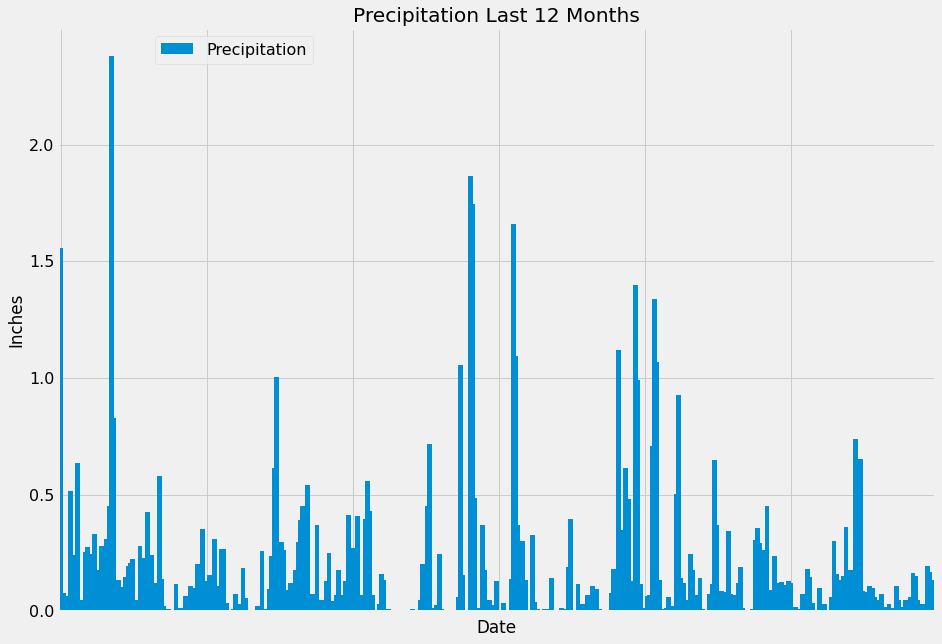

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
axis = precipitation_df.plot(kind = "bar", width=2, figsize=(14,10))
plt.locator_params(axis='x', nbins=6)
axis.xaxis.set_major_formatter(plt.NullFormatter())
axis.tick_params(axis='y', labelsize=16)
axis.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig("Images/Precipitation.png")
plt.show

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count() 

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stations[0][0]
most_active_station = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= one_yr_before).all()

temp_observation_df = pd.DataFrame(temp_observation, columns=["Station", "tobs"])

temp_observation_df.set_index("Station", inplace = True)
temp_observation_df.head()

,tobs
Station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


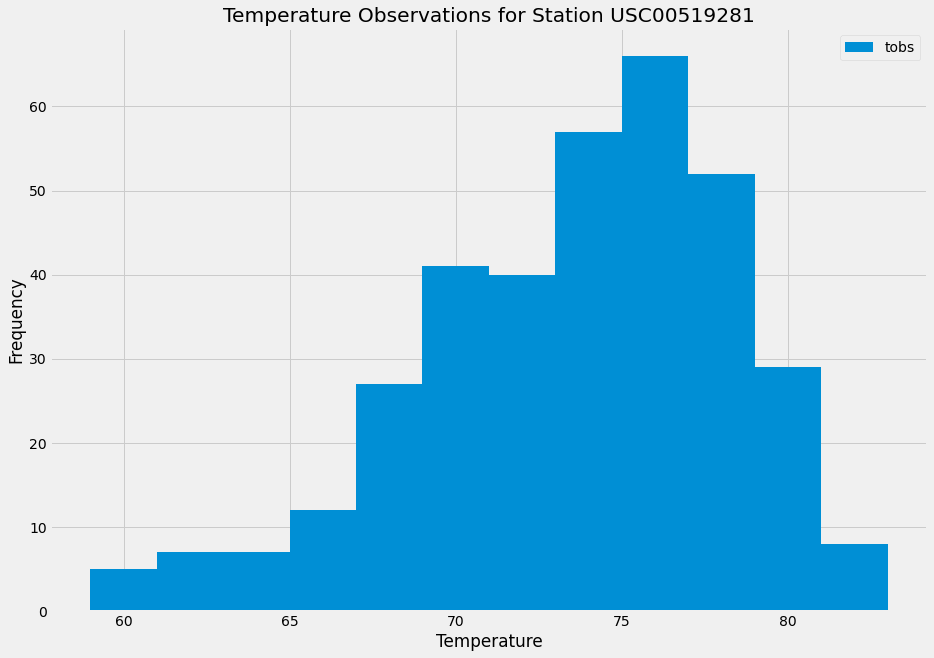

In [17]:
temp_observation_df.plot.hist(by="Station", figsize=(14,10), bins=12)
plt.title("Temperature Observations for Station " + most_active_station)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("Images/Temperature.png")
plt.show()

# Close session

In [18]:
# Close Session
session.close()